<h1 style="color:blue">Praktikum 2. EstNLTK</h1>
<h3 style="color:blue">Teksti segmenteerimine, morfoloogiline analüüs, õigekirjakontroll. Sõnapilved</h3>

Tänases praktikumis teeme lähemalt tutvust eesti keele töötlemiseks mõeldud Pythoni teegiga [EstNLTK](https://github.com/estnltk/estnltk). 
Alustame kõige põhilisemast: teksti segmenteerimine sõnadeks ja lauseteks ning morfoloogilise analüüsi teostamine. 
Need sammud on vajalikud enamiku keeletöötlusülesannete lahendamisel: kui suudame tekstist kätte saada laused ja sõnad, ning filtreerida neid lemmade, sõnaliikide ja morfoloogilise info järgi, saame ka otsida sõna esinemisi sõnavormist (käändest/pöördest) sõltumata, luua sõnade/lemmade sagedusloendeid ning visualiseerida neid näiteks sõnapilvede abil. 
Morfoloogilise analüüsi alusel saab ka tuvastada õigekirjavigu, mida on võimalik spelleri abil parandada.

**NB!** Edasine osa juhendist eeldab, et EstNLTK versioon 1.6 on installitud keskkonda, milles käesolev _notebook_ käivitatud on. Kui selline keskkond on veel loomata või ei mäleta, kuidas aktiveerida jms, siis tasub vaadata 1. praktikumi PDF-juhendit. Kui tekib probleeme, küsige julgelt abi: EstNLTK töölesaamine on oluline, kuna seda läheb vaja lisaks tänasele ka kõigis järgmistes praktikumides.

### Text objekti loomine

EstNLTK olulisimaks klassiks on Text. See sisaldab analüüsitavat teksti, teksti metaandmeid ning analüüsi käigus loodavaid lingvistilisi märgenduskihte. Selle kasutamiseks peame vastava klassi importima:

In [1]:
from estnltk import Text

Et oma teksti töötlema hakata, peame sellest tegema Text klassi objekti:

In [2]:
my_sentences = "Mees peeti kinni ja viidi Tartu vanglasse. Sinna pidi ta jääma kolmeks kuuks."

In [3]:
# Teeme oma teksti Text objektiks
text = Text(my_sentences)

In [4]:
text

text
Mees peeti kinni ja viidi Tartu vanglasse. Sinna pidi ta jääma kolmeks kuuks.


Atribuudi text kaudu saab algse teksti uuesti sõnena kätte:

In [5]:
text.text

'Mees peeti kinni ja viidi Tartu vanglasse. Sinna pidi ta jääma kolmeks kuuks.'

### Märgenduskihtide loomine Text objektile

Meetodi tag_layer() abil lisatakse Text-ile märgenduskihid, rakendades selleks EstNLTK tööahelas olevaid märgendajaid. Kui tag_layer() kutsutakse välja ilma kihte täpsustava sisendargumendita, siis teostatakse standardne analüüsitöövoog, mis hõlmab teksti segmenteerimist - jagamist lauseteks ja sõnadeks - ning morfoloogilist analüüsi ja ühestamist.

### Teksti segmenteerimine

Keeleandmete analüüsimiseks on esmalt vaja tekst tükeldada -- jagada lauseteks ja sõnadeks. 
Esmapilgul võib see tunduda ehk lihtne ülesanne, mille lahendamiseks piisaks standardteegi [_split()_](https://docs.python.org/3.5/library/stdtypes.html#str.split) meetodist.
Aga kui uurida tühikute ja punktuatsiooni kasutust tekstides detailsemalt, võib märgata üksjagu juhte, kus lihtne _split()_ rakendamine ei tööta.
Näiteks lauses

    Rattaralli toimub 29. mail 2016 ning selle stardi- ja finišipaik on Tartu kesklinnas, Turu tänaval.
  
on küll kaks punkti, aga ainult viimane tähistab lauselõppu -- **lausestaja** peab kuidagi aru saama, et kuupäeva järel olev punkt pole lauselõpp.

Ka teksti sõnedeks jagaja ehk **sõnestaja** peab olema kavalam kui tavaline *split()* : lisaks sõnade eraldamisele tühikute järgi tuleb ka punktuatsioonisümbolid sõnadest lahku tõsta: see on vajalik nii kõige lihtsamal sõnaotsingul, sõnade loendamisel kui ka edasisel automaattöötlemisel. Lisaks tuleb tegeleda probleemidega, kus sõnad on kogemata kokku kirjutatud, näiteks tekstis
    
    Iga päev teeme valikuid.Valime kõike alates pesupulbrist ja lõpetades poliitikutega. 

tuleb tuvastada, et `valikuid.Valime` ei ole mitte tavaline sõna, vaid seal on tarvis kaks "kokku kleebitud" sõna lahku tõsta.

Sedalaadi teksti segmenteerimise probleemidega tegeleb EstNLTK meie eest. 
Seega võime teksti lihtsalt failist sisse lugeda, konverteerida Text objektiks, märgendada peale vastavad kihid ning seejärel küsida lauseid ja sõnu.

EstNLTK-s on kaks viisi Text objektilt märgenduskihi küsimiseks:

* indeksi (sõne) järgi: text['words']
* atribuudi järgi: text.words

Tulemuste poolest on mõlemad viisid võrdsed: tagastatakse Layer objekt, mis on sisuliselt järjend märgendustest.

Tekstile märgendab vastavad kihid peale tag_layer() meetod. Kui vaatame tag_layer() meetodi poolt vaikimisi peale märgitud kihte, näeme, et neid on 5: sentences (laused), tokens (sõned), compound_tokens (liitsõned), words (sõnad), morph_analysis (morfoloogiline analüüs).

In [6]:
text.tag_layer()

Text(text='Mees peeti kinni ja viidi Tartu vanglasse. Sinna pidi ta jääma kolmeks kuuks.')

Standardkihtide märgendamine toimub järgmises järjekorras:
1. tokens
2. compound_tokens
3. words
4. sentences
5. morph_analysis

Sõnede ehk token'ite kiht on kasutusel selleks, et eristada korrektselt märgendatud sõnu (loeme siin sõnadeks ka kirjavahemärgid, lühendid, meiliaadressid jm) tekstis tühikutega eraldatud üksusest. Enamasti sõnad ja sõned kattuvad, kuid teatud juhtudel ühendatakse mitu sõne kokku üheks sõnaks, mis tuleb välja kihist compound_tokens (liitsõned). Näeme, et eelmises näites oli sõnade ja sõnede arv sama ning compound_tokens kiht tühi. Järgmises näites aga näeme, et sõnade ja sõnede arvud erinevad:

In [7]:
text2 = Text("Festivalil osales üle 30 000 muusikahuvilise.").tag_layer()
text2

Text(text='Festivalil osales üle 30 000 muusikahuvilise.')

In [8]:
# Tekstis esinevad sõned e tühikutega eraldatud üksused
text2.tokens

Layer(name='tokens', attributes=(), spans=SL[Span('Festivalil', [{}]),
Span('osales', [{}]),
Span('üle', [{}]),
Span('30', [{}]),
Span('000', [{}]),
Span('muusikahuvilise', [{}]),
Span('.', [{}])])

In [9]:
# Liitsõned e omavahel kokku ühendatud sõned
text2.compound_tokens

Layer(name='compound_tokens', attributes=('type', 'normalized'), spans=SL[EnvelopingSpan(['30', '000'], [{'type': ['numeric'], 'normalized': '30000'}])])

In [10]:
# Sõnad - keele väikseimad tähenduslikud üksused
text2.words

Layer(name='words', attributes=('normalized_form',), spans=SL[Span('Festivalil', [{'normalized_form': None}]),
Span('osales', [{'normalized_form': None}]),
Span('üle', [{'normalized_form': None}]),
Span('30 000', [{'normalized_form': '30000'}]),
Span('muusikahuvilise', [{'normalized_form': None}]),
Span('.', [{'normalized_form': None}])])

Kui me ei soovi märgendada kõiki standardkihte (näiteks aja ja arvutusressursside kokkuhoiu eesmärgil), võime ka tag_layer() meetodis täpsustada, millise(d) kihi(d) soovime märgendada:

In [11]:
text3 = Text('Kaitsevägi reserveerib sõjaajaks mitu tuhat erasõidukit.').tag_layer(['words'])

In [12]:
text3

Text(text='Kaitsevägi reserveerib sõjaajaks mitu tuhat erasõidukit.')

Nagu näeme, märgendati words kihi jaoks ka tokens ja compound_tokens kihid, kuna need on words kihi märgendamiseks vajalikud.

Et tekstis olevad laused koosnevad sõnadest, siis saame itereerida nii üle kogu teksti sõnade kui ka lause kaupa:

In [13]:
for sentence in text.sentences:
    print('Lause: "' + sentence.enclosing_text + '" koosneb järgmistest sõnadest: ')
    for word in sentence.words:
        print(word.text)

Lause: "Mees peeti kinni ja viidi Tartu vanglasse." koosneb järgmistest sõnadest: 
Mees
peeti
kinni
ja
viidi
Tartu
vanglasse
.
Lause: "Sinna pidi ta jääma kolmeks kuuks." koosneb järgmistest sõnadest: 
Sinna
pidi
ta
jääma
kolmeks
kuuks
.


### Ülesanne 1. Sõnade ja lausete pikkused eri autoritel (1p)
Võrrelge Indrek Hargla ja Karen Orlau tekstide lausete ja sõnade pikkusi. Selleks kirjutage funktsioon, millele antakse ette kataloogi asukoht ning mis leiab ja tagastab kõigi kataloogis olevate failide peale kokku:
* keskmise failipikkuse lausetes
* keskmise lausepikkuse sõnades
* keskmise sõnapikkuse tähemärkides

Jooksutage funktsiooni Indrek Hargla juttudel (kataloogis *hargla_texts*) ning Karen Orlau juttudel (kataloogis *orlau_texts*).

**Vihjeid:**
* Tekstide kodeeringuks on utf-8;
* Lausete ja sõnade arvu leidmiseks tekstidest kasutage EstNLTK-d;
* Kataloogi kõigi failide läbimisel on abiks [os.listdir](https://docs.python.org/3/library/os.html#os.listdir) - vt näidet:

In [14]:
import os
path = 'dummy_folder/'
for file in os.listdir(path):
    filename = os.path.join(path, file) 
    with open(filename, "r", encoding = 'utf-8') as fin:
        print(filename)
        print(fin.read())    

dummy_folder/file1.txt
Eestil on terve rida rahvusmüüte, mis pole tõesed ja on moonutused, kui mitte otse valed.

dummy_folder/file2.txt
Ühel õhtul toidupoodi minnes leidsin eest lagedad võiletid.



### Morfoloogiline analüüs

Eesti keeles on sõnadel teatavasti palju erinevaid vorme, nt nimisõnu saab kasutada 14 käändes ning lisaks muuta arvus (ainsus/mitmus).
Teksti töötluse seisukohast on aga tihti kasulik käsitleda ühe sõna kõiki vorme koos.
Siin tulebki appi morfoloogiline analüüs.
Lihtsustatult öeldes tegeleb morfoloogiline analüüs sõna struktuuri kindlakstegemisega: millistest tükkidest sõna koosneb? 
Sellise analüüsi käigus selgub aga ka palju muud kasulikku: milline on sõna algvorm, millist liiki sõnaga on tegu ja millised on tükkidele vastavad grammatilised kategooriad.

Morfoloogiline analüüs lisatakse tekstile tag_layer() meetodi abil vaikimisi, saame seda vaadata kihist morph_analysis. Nagu näeme, siis morfoloogiline analüüs teostatakse just tähenduslikel üksustel e sõnadel, mitte tühikutega eraldatud sõnedel:

In [15]:
text2.morph_analysis

Layer(name='morph_analysis', attributes=('normalized_text', 'lemma', 'root', 'root_tokens', 'ending', 'clitic', 'form', 'partofspeech'), spans=SL[Span('Festivalil', [{'normalized_text': 'Festivalil', 'lemma': 'festival', 'root': 'festival', 'root_tokens': ['festival'], 'ending': 'l', 'clitic': '', 'form': 'sg ad', 'partofspeech': 'S'}]),
Span('osales', [{'normalized_text': 'osales', 'lemma': 'osalema', 'root': 'osale', 'root_tokens': ['osale'], 'ending': 's', 'clitic': '', 'form': 's', 'partofspeech': 'V'}]),
Span('üle', [{'normalized_text': 'üle', 'lemma': 'üle', 'root': 'üle', 'root_tokens': ['üle'], 'ending': '0', 'clitic': '', 'form': '', 'partofspeech': 'K'}]),
Span('30 000', [{'normalized_text': '30000', 'lemma': '30000', 'root': '30000', 'root_tokens': ['30000'], 'ending': '0', 'clitic': '', 'form': '?', 'partofspeech': 'N'}]),
Span('muusikahuvilise', [{'normalized_text': 'muusikahuvilise', 'lemma': 'muusikahuviline', 'root': 'muusika_huviline', 'root_tokens': ['muusika', 'huviline'], 'ending': '0', 'clitic': '', 'form': 'sg g', 'partofspeech': 'S'}]),
Span('.', [{'normalized_text': '.', 'lemma': '.', 'root': '.', 'root_tokens': ['.'], 'ending': '', 'clitic': '', 'form': '', 'partofspeech': 'Z'}])])

Nagu näeme, sisaldab morfoloogilise analüüsi kiht hulka atribuute: *text* ja *normalized_text* olid juba sõnade kihil, ent juurde on lisatud *lemma* (sõna algvorm e lemma), *root* (tüvi), *root_tokens* (tüveosised), *ending* (käände-/pöördelõpp), *clitic* (kliitik - gi/ki liide), *form* (sõna morfoloogiline vorm), *partofspeech* (sõnaliik).

#### Sõnade lemmad

Morfoloogilise analüüsi üks olulisemaid tulemusi on see, et erinevad vormid taandatakse ühele kindlale kujule: leitakse iga sõna algvorm ehk **lemma**.
Nimisõnade puhul on selleks enamasti ainsuse nimetava vorm (nt sõnade *oad, ubade, ubasid* lemmaks on *uba*), tegusõnade puhul aga *ma*-lõpuline vorm (nt sõnade *nägin, näeme, näe* algvorm on *nägema*).

EstNLTK-s saab lemmad kätte morph_analysis kihist vastavat atribuuti küsides:

In [16]:
text2.morph_analysis.lemma

,lemma
0,festival
1,osalema
2,üle
3,30000
4,muusikahuviline
5,.


Soovi korral võimeseda tabeli asemel vaadata ka print käsu abil listina:

In [17]:
print(text2.morph_analysis.lemma)

[['festival'], ['osalema'], ['üle'], ['30000'], ['muusikahuviline'], ['.']]


Näeme, et iga lemma on omakorda eraldi järjendis. Järjendit kasutatakse seetõttu, et analüüs ei pruugi alati olla üheselt määratav: ühe sõna morfoloogiliseks tõlgendamiseks võib olla rohkem kui üks võimalus. Näiteks järgmises lauses leidub tekstisõnale "päikese" kaks võimalikku lemmat:

In [18]:
text4 = Text('Päikese sillerdav helk valgustas mäetippu.').tag_layer()

In [19]:
text4.morph_analysis

Layer(name='morph_analysis', attributes=('normalized_text', 'lemma', 'root', 'root_tokens', 'ending', 'clitic', 'form', 'partofspeech'), spans=SL[Span('Päikese', [{'normalized_text': 'Päikese', 'lemma': 'päike', 'root': 'päike', 'root_tokens': ['päike'], 'ending': '0', 'clitic': '', 'form': 'sg g', 'partofspeech': 'S'}, {'normalized_text': 'Päikese', 'lemma': 'päikene', 'root': 'päikene', 'root_tokens': ['päikene'], 'ending': '0', 'clitic': '', 'form': 'sg g', 'partofspeech': 'S'}]),
Span('sillerdav', [{'normalized_text': 'sillerdav', 'lemma': 'sillerdav', 'root': 'sillerda=v', 'root_tokens': ['sillerdav'], 'ending': '0', 'clitic': '', 'form': 'sg n', 'partofspeech': 'A'}]),
Span('helk', [{'normalized_text': 'helk', 'lemma': 'helk', 'root': 'helk', 'root_tokens': ['helk'], 'ending': '0', 'clitic': '', 'form': 'sg n', 'partofspeech': 'S'}]),
Span('valgustas', [{'normalized_text': 'valgustas', 'lemma': 'valgustama', 'root': 'valgusta', 'root_tokens': ['valgusta'], 'ending': 's', 'clitic': '', 'form': 's', 'partofspeech': 'V'}]),
Span('mäetippu', [{'normalized_text': 'mäetippu', 'lemma': 'mäetipp', 'root': 'mäe_tipp', 'root_tokens': ['mäe', 'tipp'], 'ending': '0', 'clitic': '', 'form': 'sg p', 'partofspeech': 'S'}]),
Span('.', [{'normalized_text': '.', 'lemma': '.', 'root': '.', 'root_tokens': ['.'], 'ending': '', 'clitic': '', 'form': '', 'partofspeech': 'Z'}])])

In [20]:
print(text4.morph_analysis.lemma)

[['päike', 'päikene'], ['sillerdav'], ['helk'], ['valgustama'], ['mäetipp'], ['.']]


#### Sõnaliigid ja grammatilised kategooriad

Laias laastus jagunevad sõnad _käändsõnadeks_ (nimi-, omadus-, ase-, arvsõnad), _pöördsõnadeks_ (tegusõnad e verbid) ning _muutumatuteks sõnadeks_ (sidesõnad, määrsõnad, kaassõnad, lühendid, lausemärgid).
Sõnaliik (ingl *part of speech*) ütleb meile esmajoones seda, millist infot sõna kohta analüüsil leida võib: käändsõnade puhul leitakse analüüsi käigus sõna kääne ja arv ning pöördsõnade puhul leitakse (grammatiline) isik, kõneviis, aeg, arv, tegumood ja kõneliik. 
Muutumatud sõnad (nt sidesõnad *ja*, *ning*, *või*) esinevad aga alati ühel kujul ning morfoloogilisel tasandil me nende kohta mingit lisainfot ei leiagi.

EstNLTK-s saab teksti sõnaliigid kätte atribuuti 'partofspeech' küsides:

In [21]:
text2.morph_analysis.partofspeech

,partofspeech
0,S
1,V
2,K
3,N
4,S
5,Z


Nagu väljundist näha, kasutatakse sõnaliikide tähistamiseks lühendeid (_S_ - substantiiv e nimisõna, _V_ - verb e tegusõna jne). Lühendid on lahti kirjutatud [selles tabelis](https://github.com/estnltk/estnltk/blob/devel_1.6/tutorials/nlp_pipeline/A_02_morphology_tables.ipynb#Table:-POS-tag-descriptions).

Kui on tarvis sõnade morfoloogiat detailsemalt uurida, siis *text.morph_analysis.form* abil saab kätte ka sõnade grammatilised kategooriad (nt käändsõnade käände ja arvu).
Grammatilised kategooriad on samuti toodud lühenditena, käändsõnade kategoorialühendid on lahti seletatud [siin](https://github.com/estnltk/estnltk/blob/devel_1.6/tutorials/nlp_pipeline/A_02_morphology_tables.ipynb#Table:-Noun-form-descriptions-(Vabamorf)) ning verbide omad [siin](https://github.com/estnltk/estnltk/blob/devel_1.6/tutorials/nlp_pipeline/A_02_morphology_tables.ipynb#Table:-Verb-form-descriptions-(Vabamorf)).
Käesolevas praktikumis meil aga sellist detailsust tarvis pole, esialgu piisab teadmisest, et see info on vajadusel olemas.

In [22]:
text2.morph_analysis.form

,form
0,sg ad
1,s
2,
3,?
4,sg g
5,


### Morfoloogilise analüüsi vaikesätted

Vaikimisi tehakse morfoloogiline analüüs alati koos **ühestamise**, **oletamise** ja **pärisnimeanalüüside pakkumisega**. Mida see tähendab? 

**Morfoloogiline ühestamine**: kui ühe sõnavormi analüüsimiseks on mitu võimalust - näiteks sõna "peeti" võib olla nii vorm nimisõnast "peet" kui ka tegusõnast "pidama" - , siis valitakse välja antud (lause)kontekstis kõige tõenäolisem tõlgendus. Seejuures jääb siiski mõningatel juhtudel mitmesus alles, nt järgmises näites on sõnal "surnud" neli analüüsivarianti.

In [23]:
Text("Mees oli surnud.").tag_layer().morph_analysis

Layer(name='morph_analysis', attributes=('normalized_text', 'lemma', 'root', 'root_tokens', 'ending', 'clitic', 'form', 'partofspeech'), spans=SL[Span('Mees', [{'normalized_text': 'Mees', 'lemma': 'mees', 'root': 'mees', 'root_tokens': ['mees'], 'ending': '0', 'clitic': '', 'form': 'sg n', 'partofspeech': 'S'}]),
Span('oli', [{'normalized_text': 'oli', 'lemma': 'olema', 'root': 'ole', 'root_tokens': ['ole'], 'ending': 'i', 'clitic': '', 'form': 's', 'partofspeech': 'V'}]),
Span('surnud', [{'normalized_text': 'surnud', 'lemma': 'surema', 'root': 'sure', 'root_tokens': ['sure'], 'ending': 'nud', 'clitic': '', 'form': 'nud', 'partofspeech': 'V'}, {'normalized_text': 'surnud', 'lemma': 'surnud', 'root': 'surnud', 'root_tokens': ['surnud'], 'ending': '0', 'clitic': '', 'form': '', 'partofspeech': 'A'}, {'normalized_text': 'surnud', 'lemma': 'surnud', 'root': 'surnud', 'root_tokens': ['surnud'], 'ending': '0', 'clitic': '', 'form': 'sg n', 'partofspeech': 'A'}, {'normalized_text': 'surnud', 'lemma': 'surnud', 'root': 'surnud', 'root_tokens': ['surnud'], 'ending': 'd', 'clitic': '', 'form': 'pl n', 'partofspeech': 'A'}]),
Span('.', [{'normalized_text': '.', 'lemma': '.', 'root': '.', 'root_tokens': ['.'], 'ending': '', 'clitic': '', 'form': '', 'partofspeech': 'Z'}])])

 * _Lingivstiline vahemärkus:_ näites esinev sõna "surnud" mitmesus on üsna tüüpiline ka teistele _nud_-lõpulistele sõnadele: ühest küljest võib _nud_-lõpulist sõna tõlgendada kui omadussõna (`'partofspeech': 'A'`) -- kui mingi tegevuse tulemusena tekkinud "omadust", aga teisest küljest on see avatud ka verbi tõlgendusele (`'partofspeech': 'V'`) -- seda võib tõlgendada kui mingi tegevuse või protsessi seisundit (loe detailsemalt [siit](https://et.wikipedia.org/wiki/Mineviku_kesks%C3%B5na)). Sedalaadi mitmesuste lahendamine nõuab kõrgema tasandi (süntaksi, semantika) keeleanalüüsi ja seetõttu jäetakse need morfoloogilisel analüüsil targu lahendamata.

**Oletamine**: kui analüsaator ei leia tekstis esinevat sõna sõnastikust ega suuda seda analüüsida ka liitega või liitsõnaks, siis sõna kuju põhjal pakutakse eeldatav(ad) analüüs(id). Järgnevas näites kasutatud sõna "poodelungile" tänapäeva eesti keele sõnastikes ei esine, ent on eesti keele kõnelejale siiski lihtne mõista. Oletaja suudab õigesti määrata vormi, ent lemma jääb mitmeseks:

In [24]:
Text('Tüdrukud läksid poodelungile.').tag_layer().morph_analysis

Layer(name='morph_analysis', attributes=('normalized_text', 'lemma', 'root', 'root_tokens', 'ending', 'clitic', 'form', 'partofspeech'), spans=SL[Span('Tüdrukud', [{'normalized_text': 'Tüdrukud', 'lemma': 'tüdruk', 'root': 'tüdruk', 'root_tokens': ['tüdruk'], 'ending': 'd', 'clitic': '', 'form': 'pl n', 'partofspeech': 'S'}]),
Span('läksid', [{'normalized_text': 'läksid', 'lemma': 'minema', 'root': 'mine', 'root_tokens': ['mine'], 'ending': 'sid', 'clitic': '', 'form': 'sid', 'partofspeech': 'V'}]),
Span('poodelungile', [{'normalized_text': 'poodelungile', 'lemma': 'poodelung', 'root': 'poodelung', 'root_tokens': ['poodelung'], 'ending': 'le', 'clitic': '', 'form': 'sg all', 'partofspeech': 'S'}, {'normalized_text': 'poodelungile', 'lemma': 'poodelungi', 'root': 'poodelungi', 'root_tokens': ['poodelungi'], 'ending': 'le', 'clitic': '', 'form': 'sg all', 'partofspeech': 'S'}, {'normalized_text': 'poodelungile', 'lemma': 'poodelunk', 'root': 'poodelunk', 'root_tokens': ['poodelunk'], 'ending': 'le', 'clitic': '', 'form': 'sg all', 'partofspeech': 'S'}]),
Span('.', [{'normalized_text': '.', 'lemma': '.', 'root': '.', 'root_tokens': ['.'], 'ending': '', 'clitic': '', 'form': '', 'partofspeech': 'Z'}])])

**Pärisnimeanalüüside pakkumine:** kui nimisõna algab suure algustähega, võib see olla nii tavaline sõna kui ka pärisnimi (nt _Trump_ võib olla nii teatud liiki mast kaardimängus kui ka perekonnanimi). Analüsaator püüab konteksti järgi ära arvata, kummaga tegu on:

In [25]:
Text('Kapten Trumm tasus arve').tag_layer().morph_analysis

Layer(name='morph_analysis', attributes=('normalized_text', 'lemma', 'root', 'root_tokens', 'ending', 'clitic', 'form', 'partofspeech'), spans=SL[Span('Kapten', [{'normalized_text': 'Kapten', 'lemma': 'kapten', 'root': 'kapten', 'root_tokens': ['kapten'], 'ending': '0', 'clitic': '', 'form': 'sg n', 'partofspeech': 'S'}]),
Span('Trumm', [{'normalized_text': 'Trumm', 'lemma': 'Trumm', 'root': 'Trumm', 'root_tokens': ['Trumm'], 'ending': '0', 'clitic': '', 'form': 'sg n', 'partofspeech': 'H'}]),
Span('tasus', [{'normalized_text': 'tasus', 'lemma': 'tasuma', 'root': 'tasu', 'root_tokens': ['tasu'], 'ending': 's', 'clitic': '', 'form': 's', 'partofspeech': 'V'}]),
Span('arve', [{'normalized_text': 'arve', 'lemma': 'arve', 'root': 'arve', 'root_tokens': ['arve'], 'ending': '0', 'clitic': '', 'form': 'sg g', 'partofspeech': 'S'}])])

In [26]:
Text('Suur Trumm oli orkestrist puudu.').tag_layer().morph_analysis

Layer(name='morph_analysis', attributes=('normalized_text', 'lemma', 'root', 'root_tokens', 'ending', 'clitic', 'form', 'partofspeech'), spans=SL[Span('Suur', [{'normalized_text': 'Suur', 'lemma': 'suur', 'root': 'suur', 'root_tokens': ['suur'], 'ending': '0', 'clitic': '', 'form': 'sg n', 'partofspeech': 'A'}]),
Span('Trumm', [{'normalized_text': 'Trumm', 'lemma': 'trumm', 'root': 'trumm', 'root_tokens': ['trumm'], 'ending': '0', 'clitic': '', 'form': 'sg n', 'partofspeech': 'S'}]),
Span('oli', [{'normalized_text': 'oli', 'lemma': 'olema', 'root': 'ole', 'root_tokens': ['ole'], 'ending': 'i', 'clitic': '', 'form': 's', 'partofspeech': 'V'}]),
Span('orkestrist', [{'normalized_text': 'orkestrist', 'lemma': 'orkester', 'root': 'orkester', 'root_tokens': ['orkester'], 'ending': 'st', 'clitic': '', 'form': 'sg el', 'partofspeech': 'S'}]),
Span('puudu', [{'normalized_text': 'puudu', 'lemma': 'puudu', 'root': 'puudu', 'root_tokens': ['puudu'], 'ending': '0', 'clitic': '', 'form': '', 'partofspeech': 'D'}]),
Span('.', [{'normalized_text': '.', 'lemma': '.', 'root': '.', 'root_tokens': ['.'], 'ending': '', 'clitic': '', 'form': '', 'partofspeech': 'Z'}])])

#### Morfoloogilise analüüsi sätete muutmine

Nii ühestajat, oletajat kui pärisnimede pakkujat on võimalik *Text* objekti morfoloogilisel märgendamisel välja lülitada. Morfanalüsaatori parameetrite muutmiseks peame kasutama *resolver*it, mis käib järgmiselt:

In [27]:
from estnltk.resolve_layer_dag import make_resolver

# Loome resolveri
resolver = make_resolver(
                 disambiguate=False, # keelame ühestamise
                 guess=True,
                 propername=True)

In [28]:
# Teostame morfoloogilise analüüsi ilma ühestamiseta
text = Text("Kapten Trumm tasus arve.")
text.tag_layer(resolver=resolver)

Text(text='Kapten Trumm tasus arve.')

In [29]:
text.morph_analysis

Layer(name='morph_analysis', attributes=('normalized_text', 'lemma', 'root', 'root_tokens', 'ending', 'clitic', 'form', 'partofspeech', '_ignore'), spans=SL[Span('Kapten', [{'normalized_text': 'Kapten', 'lemma': 'Kapten', 'root': 'Kapten', 'root_tokens': ['Kapten'], 'ending': '0', 'clitic': '', 'form': 'sg n', 'partofspeech': 'H', '_ignore': False}, {'normalized_text': 'Kapten', 'lemma': 'kapten', 'root': 'kapten', 'root_tokens': ['kapten'], 'ending': '0', 'clitic': '', 'form': 'sg n', 'partofspeech': 'S', '_ignore': False}]),
Span('Trumm', [{'normalized_text': 'Trumm', 'lemma': 'Trumm', 'root': 'Trumm', 'root_tokens': ['Trumm'], 'ending': '0', 'clitic': '', 'form': 'sg n', 'partofspeech': 'H', '_ignore': False}, {'normalized_text': 'Trumm', 'lemma': 'trumm', 'root': 'trumm', 'root_tokens': ['trumm'], 'ending': '0', 'clitic': '', 'form': 'sg n', 'partofspeech': 'S', '_ignore': False}]),
Span('tasus', [{'normalized_text': 'tasus', 'lemma': 'tasu', 'root': 'tasu', 'root_tokens': ['tasu'], 'ending': 's', 'clitic': '', 'form': 'sg in', 'partofspeech': 'S', '_ignore': False}, {'normalized_text': 'tasus', 'lemma': 'tasuma', 'root': 'tasu', 'root_tokens': ['tasu'], 'ending': 's', 'clitic': '', 'form': 's', 'partofspeech': 'V', '_ignore': False}]),
Span('arve', [{'normalized_text': 'arve', 'lemma': 'arv', 'root': 'arv', 'root_tokens': ['arv'], 'ending': 'e', 'clitic': '', 'form': 'pl p', 'partofspeech': 'S', '_ignore': False}, {'normalized_text': 'arve', 'lemma': 'arve', 'root': 'arve', 'root_tokens': ['arve'], 'ending': '0', 'clitic': '', 'form': 'sg g', 'partofspeech': 'S', '_ignore': False}, {'normalized_text': 'arve', 'lemma': 'arve', 'root': 'arve', 'root_tokens': ['arve'], 'ending': '0', 'clitic': '', 'form': 'sg n', 'partofspeech': 'S', '_ignore': False}]),
Span('.', [{'normalized_text': '.', 'lemma': '.', 'root': '.', 'root_tokens': ['.'], 'ending': '', 'clitic': '', 'form': '', 'partofspeech': 'Z', '_ignore': False}])])

Näeme, et ühestaja väljalülitamisel (`disambiguate = False`) antakse välja kõik võimalikud morfoloogilise analüüsi tõlgendused sõnade kohta (k.a sellised, mis konteksti kuidagi ei sobi).

Kui lülitame välja nii ühestamise kui oletamised (guess=False, propername=False, disambiguate=False), saame kasutada morfanalüsaatorit selleks, et leida tundmatuid sõnu - sõnu, mis kas ei ole korrektselt kirjutatud või ei esine kirjakeeles. Uut *resolver*it luues peame arvestama ka asjaoluga, et *resolver* märgib tekstile peale ainult need kihid, mida veel ei ole. Ehk siis, et näha parameetrite muutmisel tekkivaid muutusi, peame kas looma uue Text objekti või kustutama ära vastava kihi.

In [30]:
text.pop_layer('morph_analysis')  # Kustutame ära morfoloogilise analüüsi kihi

Layer(name='morph_analysis', attributes=('normalized_text', 'lemma', 'root', 'root_tokens', 'ending', 'clitic', 'form', 'partofspeech', '_ignore'), spans=SL[Span('Kapten', [{'normalized_text': 'Kapten', 'lemma': 'Kapten', 'root': 'Kapten', 'root_tokens': ['Kapten'], 'ending': '0', 'clitic': '', 'form': 'sg n', 'partofspeech': 'H', '_ignore': False}, {'normalized_text': 'Kapten', 'lemma': 'kapten', 'root': 'kapten', 'root_tokens': ['kapten'], 'ending': '0', 'clitic': '', 'form': 'sg n', 'partofspeech': 'S', '_ignore': False}]),
Span('Trumm', [{'normalized_text': 'Trumm', 'lemma': 'Trumm', 'root': 'Trumm', 'root_tokens': ['Trumm'], 'ending': '0', 'clitic': '', 'form': 'sg n', 'partofspeech': 'H', '_ignore': False}, {'normalized_text': 'Trumm', 'lemma': 'trumm', 'root': 'trumm', 'root_tokens': ['trumm'], 'ending': '0', 'clitic': '', 'form': 'sg n', 'partofspeech': 'S', '_ignore': False}]),
Span('tasus', [{'normalized_text': 'tasus', 'lemma': 'tasu', 'root': 'tasu', 'root_tokens': ['tasu'], 'ending': 's', 'clitic': '', 'form': 'sg in', 'partofspeech': 'S', '_ignore': False}, {'normalized_text': 'tasus', 'lemma': 'tasuma', 'root': 'tasu', 'root_tokens': ['tasu'], 'ending': 's', 'clitic': '', 'form': 's', 'partofspeech': 'V', '_ignore': False}]),
Span('arve', [{'normalized_text': 'arve', 'lemma': 'arv', 'root': 'arv', 'root_tokens': ['arv'], 'ending': 'e', 'clitic': '', 'form': 'pl p', 'partofspeech': 'S', '_ignore': False}, {'normalized_text': 'arve', 'lemma': 'arve', 'root': 'arve', 'root_tokens': ['arve'], 'ending': '0', 'clitic': '', 'form': 'sg g', 'partofspeech': 'S', '_ignore': False}, {'normalized_text': 'arve', 'lemma': 'arve', 'root': 'arve', 'root_tokens': ['arve'], 'ending': '0', 'clitic': '', 'form': 'sg n', 'partofspeech': 'S', '_ignore': False}]),
Span('.', [{'normalized_text': '.', 'lemma': '.', 'root': '.', 'root_tokens': ['.'], 'ending': '', 'clitic': '', 'form': '', 'partofspeech': 'Z', '_ignore': False}])])

In [31]:
resolver2 = make_resolver(
                 disambiguate=False, # keelame ühestamise
                 guess=False, # keelame oletamise
                 propername=False) # keelame pärisnimede oletamise

In [32]:
text = Text('Tüdrukud läksid poodelungile.').tag_layer(resolver = resolver2)

In [33]:
text.morph_analysis

Layer(name='morph_analysis', attributes=('normalized_text', 'lemma', 'root', 'root_tokens', 'ending', 'clitic', 'form', 'partofspeech', '_ignore'), spans=SL[Span('Tüdrukud', [{'normalized_text': 'Tüdrukud', 'lemma': 'tüdruk', 'root': 'tüdruk', 'root_tokens': ['tüdruk'], 'ending': 'd', 'clitic': '', 'form': 'pl n', 'partofspeech': 'S', '_ignore': False}]),
Span('läksid', [{'normalized_text': 'läksid', 'lemma': 'minema', 'root': 'mine', 'root_tokens': ['mine'], 'ending': 'sid', 'clitic': '', 'form': 'sid', 'partofspeech': 'V', '_ignore': False}]),
Span('poodelungile', [{'normalized_text': None, 'lemma': None, 'root': None, 'root_tokens': None, 'ending': None, 'clitic': None, 'form': None, 'partofspeech': None, '_ignore': False}]),
Span('.', [{'normalized_text': None, 'lemma': None, 'root': None, 'root_tokens': None, 'ending': None, 'clitic': None, 'form': None, 'partofspeech': None, '_ignore': False}])])

Näeme, et oletaja väljalülitamisel (guess = False) jäävad analüsaatori jaoks tundmatutele sõnadele analüüsid määramata.

**NB!** Oletamise (guess = False) väljalülitamine toimib ainult siis, kui ka ühestamine ja oletamine on välja lülitatud. Kui kasutada ainult guess = False, siis seda ignoreeritakse ning morfanalüüs teostatakse vaikeparameetritega. Seda seetõttu, et ühestaja suudab ühestada vaid teksti, kus igal sõnal on analüüs olemas.

**NB2!** Kui oletamine on välja lülitatud, jäävad analüüsid määramata ka kirjavahemärkidele. Seetõttu ongi eelmises näites kaks `None` analüüsi: üks sõna 'poodelungile' kohta ja teine '.' kohta.

Pärisnimede pakkuja väljalülitamisel (`propername = False`) kaovad ära pärisnimetõlgendused:

In [34]:
resolver3 = make_resolver(
                 disambiguate=True, # keelame ühestamise
                 guess=True, # keelame oletamise
                 propername=False) # keelame pärisnimede oletamise

In [35]:
text = Text('Kapten Trumm tasus arve.').tag_layer(resolver = resolver3)

In [36]:
text.morph_analysis

Layer(name='morph_analysis', attributes=('normalized_text', 'lemma', 'root', 'root_tokens', 'ending', 'clitic', 'form', 'partofspeech'), spans=SL[Span('Kapten', [{'normalized_text': 'Kapten', 'lemma': 'kapten', 'root': 'kapten', 'root_tokens': ['kapten'], 'ending': '0', 'clitic': '', 'form': 'sg n', 'partofspeech': 'S'}]),
Span('Trumm', [{'normalized_text': 'Trumm', 'lemma': 'trumm', 'root': 'trumm', 'root_tokens': ['trumm'], 'ending': '0', 'clitic': '', 'form': 'sg n', 'partofspeech': 'S'}]),
Span('tasus', [{'normalized_text': 'tasus', 'lemma': 'tasuma', 'root': 'tasu', 'root_tokens': ['tasu'], 'ending': 's', 'clitic': '', 'form': 's', 'partofspeech': 'V'}]),
Span('arve', [{'normalized_text': 'arve', 'lemma': 'arve', 'root': 'arve', 'root_tokens': ['arve'], 'ending': '0', 'clitic': '', 'form': 'sg n', 'partofspeech': 'S'}]),
Span('.', [{'normalized_text': '.', 'lemma': '.', 'root': '.', 'root_tokens': ['.'], 'ending': '', 'clitic': '', 'form': '', 'partofspeech': 'Z'}])])

### Ülesanne 2.  Morfoloogilise analüüsi katsetamine (1p)

Leidke praktikumi materjalide hulgast fail *parasiitlusest.txt*. Lugege fail sisse, konverteerige *Text* objektiks ning teostage morfoloogiline analüüs. Täiendage oma koodi nii, et saaks vastata järgmistele küsimustele:

A. Kui suur on dokumendi sõnavara (ehk unikaalsete tekstisõnede arv) ilma lemmatiseerimata? Vaadake normaliseeritud sõnu ehk atribuuti *normalized_text*. Mitmeseks jäänud analüüside puhul võib vaadata ainult esimest varianti.

B. Kui suur on dokumendi sõnavara lemmatiseeritult?

C. Mitu % tekstisõnadest jääb mitmeseks (on mitu analüüsi) koos morfoloogilise ühestamisega? (Ei ole vaja vaadata unikaalseid sõnu.)

D. Mitu % tekstisõnadest jääb mitmeseks ilma morfoloogilise ühestamiseta?

**Vihjed:**
* Teksti kodeeringuks on utf-8
* Analüüside arvu saame kätte *morph_analysis* kihi *annotations* atribuudi abil:

In [37]:
text = Text('Hundid söönud, lambad terved.').tag_layer()
for word in text.morph_analysis:
    print(len(word.annotations))

1
4
1
1
1
1


###  Õigekirjakontroll

EstNLTK-s on olemas tööriist õigekirjakontrolli jaoks, mida saab kasutada järgmiselt:

In [2]:
from estnltk.taggers import SpellCheckRetagger

# Loome kirjavigadega teksti ja märgime sellele peale sõnade kihi
text = Text('Ma tahax minna järve äärde ja püda hauge, katikaid ja karpe.').tag_layer(['words'])

# Loome õigekirjakontrollija
spelling_tagger=SpellCheckRetagger()

# Lisame vigastele sõnadele normaliseeritud kuju
spelling_tagger.retag(text)

# Vaatame tulemusi
text.words

Layer(name='words', attributes=('normalized_form',), spans=SL[Span('Ma', [{'normalized_form': None}]),
Span('tahax', [{'normalized_form': 'tahaks'}]),
Span('minna', [{'normalized_form': None}]),
Span('järve', [{'normalized_form': None}]),
Span('äärde', [{'normalized_form': None}]),
Span('ja', [{'normalized_form': None}]),
Span('püda', [{'normalized_form': 'püüda'}]),
Span('hauge', [{'normalized_form': None}]),
Span(',', [{'normalized_form': None}]),
Span('katikaid', [{'normalized_form': 'kaikaid'}]),
Span('ja', [{'normalized_form': None}]),
Span('karpe', [{'normalized_form': None}]),
Span('.', [{'normalized_form': None}])])

Nagu näha, siis algses lauses on kolmest veast kahele korrektne vaste leitud, kolmandale aga mitte.

Morfoloogilisel analüüsil võetakse õigekirjavigade parandusi arvesse. Kui sõna 'normalized_form' sisaldab parandatud varianti, siis kasutatakse morfoloogilisel analüüsil seda, mitte algset varianti. Et seda näha, märgime parandatud tekstile peale morfoloogilise analüüsi kihi:

In [39]:
text.tag_layer(['morph_analysis'])
text.morph_analysis

Layer(name='morph_analysis', attributes=('normalized_text', 'lemma', 'root', 'root_tokens', 'ending', 'clitic', 'form', 'partofspeech'), spans=SL[Span('Ma', [{'normalized_text': 'Ma', 'lemma': 'mina', 'root': 'mina', 'root_tokens': ['mina'], 'ending': '0', 'clitic': '', 'form': 'sg n', 'partofspeech': 'P'}]),
Span('tahax', [{'normalized_text': 'tahaks', 'lemma': 'tahtma', 'root': 'taht', 'root_tokens': ['taht'], 'ending': 'ks', 'clitic': '', 'form': 'ks', 'partofspeech': 'V'}]),
Span('minna', [{'normalized_text': 'minna', 'lemma': 'minema', 'root': 'mine', 'root_tokens': ['mine'], 'ending': 'a', 'clitic': '', 'form': 'da', 'partofspeech': 'V'}]),
Span('järve', [{'normalized_text': 'järve', 'lemma': 'järv', 'root': 'järv', 'root_tokens': ['järv'], 'ending': '0', 'clitic': '', 'form': 'sg g', 'partofspeech': 'S'}]),
Span('äärde', [{'normalized_text': 'äärde', 'lemma': 'äärde', 'root': 'äärde', 'root_tokens': ['äärde'], 'ending': '0', 'clitic': '', 'form': '', 'partofspeech': 'K'}]),
Span('ja', [{'normalized_text': 'ja', 'lemma': 'ja', 'root': 'ja', 'root_tokens': ['ja'], 'ending': '0', 'clitic': '', 'form': '', 'partofspeech': 'J'}]),
Span('püda', [{'normalized_text': 'püüda', 'lemma': 'püüdma', 'root': 'püüd', 'root_tokens': ['püüd'], 'ending': 'a', 'clitic': '', 'form': 'da', 'partofspeech': 'V'}]),
Span('hauge', [{'normalized_text': 'hauge', 'lemma': 'haug', 'root': 'haug', 'root_tokens': ['haug'], 'ending': 'e', 'clitic': '', 'form': 'pl p', 'partofspeech': 'S'}]),
Span(',', [{'normalized_text': ',', 'lemma': ',', 'root': ',', 'root_tokens': [','], 'ending': '', 'clitic': '', 'form': '', 'partofspeech': 'Z'}]),
Span('katikaid', [{'normalized_text': 'kaikaid', 'lemma': 'kaigas', 'root': 'kaigas', 'root_tokens': ['kaigas'], 'ending': 'id', 'clitic': '', 'form': 'pl p', 'partofspeech': 'S'}]),
Span('ja', [{'normalized_text': 'ja', 'lemma': 'ja', 'root': 'ja', 'root_tokens': ['ja'], 'ending': '0', 'clitic': '', 'form': '', 'partofspeech': 'J'}]),
Span('karpe', [{'normalized_text': 'karpe', 'lemma': 'karp', 'root': 'karp', 'root_tokens': ['karp'], 'ending': 'e', 'clitic': '', 'form': 'pl p', 'partofspeech': 'S'}]),
Span('.', [{'normalized_text': '.', 'lemma': '.', 'root': '.', 'root_tokens': ['.'], 'ending': '', 'clitic': '', 'form': '', 'partofspeech': 'Z'}])])

Õigekirjakorrektor võib valesti kirjutatud sõna parandamiseks anda ka mitu varianti. Vaikimisi võtab SpellCheckRetagger esimese variandi, kuna mitme variandi säilitamisel võib morfoloogilise ühestamise kvaliteet kannatada. Katsetamiseks võib aga lubada ka kõik parandusvariandid, kasutades lippu `add_all_suggestions`:

In [40]:
# Create a text containing spelling mistakes
text=Text('Ma tahax minna järve äärde ja püda hauge, katikaid ja karpe.').tag_layer(['words'])

# Create spellchecker that can give multiple suggestions
spelling_tagger=SpellCheckRetagger(add_all_suggestions=True)
# Add normalizations to misspelled words
spelling_tagger.retag(text)

# Check the results
text.words

Layer(name='words', attributes=('normalized_form',), spans=SL[Span('Ma', [{'normalized_form': None}]),
Span('tahax', [{'normalized_form': 'tahaks'}, {'normalized_form': 'taha'}, {'normalized_form': 'tahad'}]),
Span('minna', [{'normalized_form': None}]),
Span('järve', [{'normalized_form': None}]),
Span('äärde', [{'normalized_form': None}]),
Span('ja', [{'normalized_form': None}]),
Span('püda', [{'normalized_form': 'püüda'}]),
Span('hauge', [{'normalized_form': None}]),
Span(',', [{'normalized_form': None}]),
Span('katikaid', [{'normalized_form': 'kaikaid'}, {'normalized_form': 'latikaid'}, {'normalized_form': 'karikaid'}, {'normalized_form': 'katikaiad'}]),
Span('ja', [{'normalized_form': None}]),
Span('karpe', [{'normalized_form': None}]),
Span('.', [{'normalized_form': None}])])

Näeme, et "katikaid" puhul on neli võimalust, kuna aga õige variant ei ole seekord esimene, siis kahjuks valitakse vale. 

Vahel võib juhtuda, et spelleril pole vigasele sõnale parandusettepanekuid. Kui on vaja tekstis määrata ära kõik vigased sõnad, hoolimata sellest, kas speller neile vaste leidis, saab kasutada lippu `add_spellchek`. See lisab sõnakihile atribuudi *spelling*, mille väärtused näitavad, kas tegu on korrektse õigekirjaga sõnaga. **NB!** Kuigi atribuudi *spelling* väärtust on näha iga normaliseeritud vormi kohta, käib atribuudi hinnang vaid tekstisõna, mitte selle normaliseeritud vormide kohta. 

In [5]:
spelling_tagger = SpellCheckRetagger(add_all_suggestions=True, add_spellcheck=True)

In [9]:
text = Text('Kas sa üldse saad arru, mida ta räägbb?').tag_layer(['words'])
spelling_tagger.retag(text)
text.words

Layer(name='words', attributes=('normalized_form', 'spelling'), spans=SL[Span('Kas', [{'normalized_form': None, 'spelling': True}]),
Span('sa', [{'normalized_form': None, 'spelling': True}]),
Span('üldse', [{'normalized_form': None, 'spelling': True}]),
Span('saad', [{'normalized_form': None, 'spelling': True}]),
Span('arru', [{'normalized_form': 'aru', 'spelling': False}, {'normalized_form': 'erru', 'spelling': False}, {'normalized_form': 'aeru', 'spelling': False}, {'normalized_form': 'atru', 'spelling': False}, {'normalized_form': 'adru', 'spelling': False}, {'normalized_form': 'Ardu', 'spelling': False}, {'normalized_form': 'tarru', 'spelling': False}, {'normalized_form': 'marru', 'spelling': False}, {'normalized_form': 'harru', 'spelling': False}]),
Span(',', [{'normalized_form': None, 'spelling': True}]),
Span('mida', [{'normalized_form': None, 'spelling': True}]),
Span('ta', [{'normalized_form': None, 'spelling': True}]),
Span('räägbb', [{'normalized_form': None, 'spelling': False}]),
Span('?', [{'normalized_form': None, 'spelling': True}])])

### Ülesanne 3. Parandame vead (2,5p)

Kasutades EstNLTK õigekirjakontrolli võimalust, kirjutage kood, mis aitab parandada kirjavigu ning laseb kasutajal tehtavate asenduste osas kaasa rääkida. Selleks peaks kood sisendiks saama teksti ning kuvama kasutajale järjest lauseid, milles esineb õigekirjakontrollija meelest ebakorrektseid sõnu. Koos lausega võiks kuvada ka, millises sõnas probleem täpselt esineb.
* Kui EstNLTK-l soovitusi ei ole, paluge kasutajal õige variant sisestada. Tühja sisestuse korral jäetakse sõna algsele kujule, kui kasutaja pakub oma variandi, asendatakse sõna lauses sellega;
* Kui vigase sõna asemel on üks soovitus, siis asendatakse sõna sellega, lause ja asendus kuvatakse kasutajale sellegipoolest;
* Kui soovitusi on mitu, kuvatakse kasutajale lause ning variandid koos järjekorranumbriga ning küsitakse kasutaja sisendit, mitmes variant valida asenduseks. Arvestage, et erinevalt Pythonist eelistavad inimesed nummerdamist üldjuhul alates 1-st; 
* Programmi töö lõppedes väljastage kasutajale tema parandatud tekst tervikuna;

Vihjeid:
* [input()](https://docs.python.org/3/library/functions.html#input) kasutaja sisendi küsimiseks 
* korrektse teksti koostamisel ei pea täpselt säilitama tühikuid ja reavahetusi, küll aga võiks tekst näha välja esinduslik ja loetav (abiks nt regulaaravaldised ja/või sõnemeetod [join()](https://docs.python.org/3/library/stdtypes.html#str.join)).

In [41]:
name = input("Mis su nimi on? ")
print("Tere, " + name + "!")

Mis su nimi on? Dage
Tere, Dage!


### Sõnapilved

Sõnapilv on populaarne tekstiliste andmete esitamise viis. Kõige lihtsam on muidugi tükeldada tekst sõnadeks ning visualiseerida kõige sagedasemad sõnad. Paraku ei pruugi see olla väga informatiivne.

Siin on näiteks toodud ühe teatrietenduse arvustuse pealt genereeritud sõnapilv. Nagu näha, on enim esindatud asesõnad, sidesõnad ja määrsõnad, mis eriti informatiivsed ei ole.

![title](wordcloud7.png)

### Ülesanne 4. Sõnapilv (1,5p)

Kaustas *teatriarvustused2* on toodud üheksa arvustust ühe teatrietenduse kohta. Koostage kaustas olevate tekstide põhjal informatiivsem sõnapilv. Kuna arvustuste puhul on huvitavad peamiselt kirjutajate poolt antud hinnangud, siis parema sõnapilve koostamiseks:
* lemmatiseerige tekstid
* kasutage sõnapilves ainult omadussõnu
* valige mõistlik hulk sõnu, mida visualiseerida - eeldatavasti sagedasemad, samas võib kasutada stoppsõnade loendit, et jätta välja sõnu, mis ei ole informatiivsed

**Vihjeid:**

* Tekstide kodeeringuks on utf-8

* Sõnapilve genereerimisel on abiks https://github.com/amueller/word_cloud teek. Kasutamiseks tuleb see installida praktikumiülesannete lahendamiseks kasutatavasse conda keskkonda käsuga

    `conda install -c conda-forge wordcloud`
    

* Sõnapilve visualiseerimiseks vajame ka matplotlib'i, mille saab installida käsuga

    `conda install matplotlib`
    

Ülaltoodud sõnapilv on genereeritud järgneva koodi abil:

In [42]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [43]:
with open("teatriarvustused2/arvustus8.txt", "r", encoding = 'utf-8') as fin:
    text = fin.read()

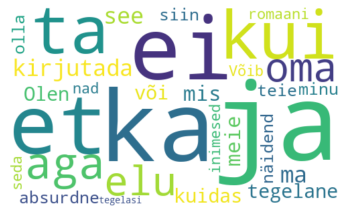

In [44]:
wordcloud = WordCloud(max_font_size = 160, max_words = 30, width = 500, height = 300, background_color = 'white').generate(text)
fig = plt.figure()
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

### Boonusülesanne.  (1p)

Vaadake Postimehe koostatud sõnapilve presidendi vabariigi aastapäeva kõne teksti pealt (pärit [siit](http://arvamus.postimees.ee/4027843/sonapilv-keda-voi-mida-mainis-kaljulaid-oma-kones-koige-enam)). Mõelge, mil moel saaks automaatse tekstitöötluse abil tulemust parandada. Genereerige uus ja parem sõnapilv (kõne teksti leiate failist *presidendi_tekst.txt*), mis oleks samuti Eesti kujuga. Näidis [siin.](https://github.com/amueller/word_cloud/blob/master/examples/masked.py)

![title](presidendipilv.png)